In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import tqdm as tqdm
import cv2
import keras
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D ,GlobalAveragePooling2D ,Flatten , Dense , Dropout , BatchNormalization
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from google.colab.patches import cv2_imshow
from skimage import data
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def load_images(path):
    classes = ['Bicycle', 'Bike','Boat','Bus','Car','Cng','Easy-bike','Horse-cart','Leguna','Rickshaw','Tractor','Truck','Van','Wheelbarrow']
    imgs = []
    labels = []
    for i in classes:
        l2 = os.listdir(path+'/'+i)

        c = 0
        for j in l2:
            img = Image.open(path+i+'/'+j).convert('RGB')
            img = img.resize(size=(250,250))
            imgs.append(np.array(img))
            labels.append(i)
            del img
            c=c+1
        print(c)
    return np.array(imgs),labels

In [ ]:
img , label=load_images("/content/drive/MyDrive/Local-Vehicles/Local-Vehicles/")

707
864
613
452
708
533
616
256
218
495


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


431
730
614
237


In [ ]:
Data_label=pd.Series(label,dtype='category')
Data_label.value_counts()

Bike           864
Truck          730
Car            708
Bicycle        707
Easy-bike      616
Van            614
Boat           613
Cng            533
Rickshaw       495
Bus            452
Tractor        431
Horse-cart     256
Wheelbarrow    237
Leguna         218
dtype: int64

In [ ]:
target=Data_label.cat.codes
target

0        0
1        0
2        0
3        0
4        0
        ..
7469    13
7470    13
7471    13
7472    13
7473    13
Length: 7474, dtype: int8

In [ ]:
Pre_trained_model=tf.keras.applications.EfficientNetV2B0(include_top=False,input_shape=(250,250,3))
input_image=tf.keras.layers.Input((250,250,3))
x=Pre_trained_model (input_image)
x=GlobalAveragePooling2D()(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(640)(x)
out=tf.keras.layers.Activation(activation='relu')(x)
model=tf.keras.Model(inputs=input_image,outputs=out)


24274472/24274472 [==============================] - 2s 0us/step


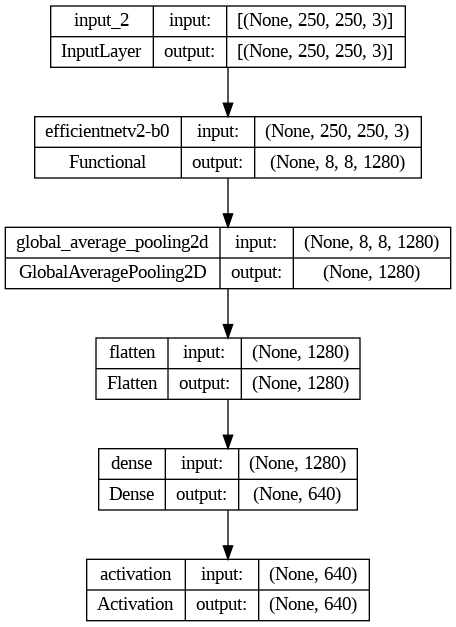

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-plant.png', show_shapes=True)

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [ ]:
def feature_extractor(img):
  feature=model.predict(img)
  return np.array(feature.reshape(-1))

In [ ]:
feat=[]
for i in img:
  i= np.expand_dims(i, axis=0)
  feat.append(feature_extractor(i))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


In [ ]:
print(len(feat))

7474


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feat,target, test_size=0.30, random_state=42)

In [ ]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
len(X_train)

8260

In [ ]:
len(y_test)

2243

In [ ]:
clf = xgb.XGBClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9402585822559073

In [ ]:
y_pred=clf.predict(X_train)
accuracy_score(y_train, y_pred)

1.0

In [ ]:
 target_names=['Bicycle', 'Bike','Boat','Bus','Car','Cng','Easy-bike','Horse-cart','Leguna','Rickshaw','Tractor','Truck','Van','Wheelbarrow']
 print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Bicycle       0.94      0.94      0.94       232
        Bike       0.98      0.95      0.96       274
        Boat       0.98      0.99      0.99       178
         Bus       0.96      0.88      0.92       136
         Car       0.97      0.94      0.95       213
         Cng       0.92      0.89      0.90       153
   Easy-bike       0.90      0.96      0.93       189
  Horse-cart       0.94      0.94      0.94        71
      Leguna       0.88      0.87      0.87        68
    Rickshaw       0.90      0.92      0.91       145
     Tractor       1.00      0.98      0.99       115
       Truck       0.91      0.97      0.94       214
         Van       0.92      0.95      0.94       176
 Wheelbarrow       0.93      0.90      0.92        79

    accuracy                           0.94      2243
   macro avg       0.94      0.93      0.94      2243
weighted avg       0.94      0.94      0.94      2243



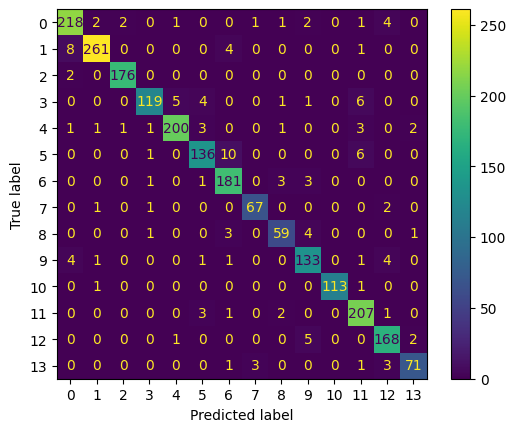

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()